# Percolation Project Group 1

### Authors: Ollie Laird, Vaughan Risdale, Max Rodrigues Rooney & George Townsend

Note: We initially had Carl Weighill in our group prior to his withdrawal from the course

### Always run this cell before working on the code

In [18]:
# Imported libraries and methods
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as inter
import scipy.optimize as opt
from scipy.stats import iqr

## Introduction

In this project we attempt to model the process of percolation through computation. We will explore left to right percolation on a standard square grid before developing these ideas by applying similar techniques to different sized and shaped grids. We will also look at another model of percolation in which we rely on probabilistic techniques to determine both the grid structure and the points at which percolation can occur. For each of these we will attempt to estimate the 'percolation threshold' or 'critical point' - the point at which the probability of percolation changes from $0$ to $1$ for an infintely sized grid. Ultimately, we hope to provide an interesting exploration of a number of percolation processes and the methods of finding the percolation threshold for such processes.

## Part 1 (core): A Visualisation of a Randomly Coloured Yellow and Blue Grid

In this section we attempt to both generate and visualise an $n \times n$ grid of yellow and blue squares, coloured according to a given probabiliy of yellow squares.

In [19]:
# This function generates a grid in the form of a 2D numpy array for the purpose of later use in testing percolation
def generate_grid(grid_size, p_yellow):
    '''
    Given grid size and probability of a square being yellow, this outputs
    a numpy array of booleans, with true representing yellow
    '''
    
    colours = np.random.rand(grid_size, grid_size) # Initialise 2d array of random numbers between 0 and 1
    if p_yellow != 0:                              # If p_yellow is set to 0 we don't change the original random number grid
        colours = colours < p_yellow               # Sets each cell to True if it's less than p_yellow, else False.
    return colours   

In [3]:
# This function displays a yellow and blue visualisation of a grid (numpy array) which is passed to it.
def display_grid(grid):
    '''
    Given a grid generated by our function 'generate_grid' this function displays our grid with yellow and blue squares
    '''
    
    plt.figure(figsize=(6,6))           # Set appropriate figure size
    plt.pcolor(grid, cmap="plasma")     # Makes the graph a rectangular grid plot with yellow and blue colour scheme
    plt.gca().set_aspect('equal')       # Set equal aspect ratio
    plt.plot() #Plots the grid
    plt.title("Percolation Grid")
    plt.show()
    return None

Running the code below we can display a $100\times100$ grid where the probability of a square being yellow is $0.6$

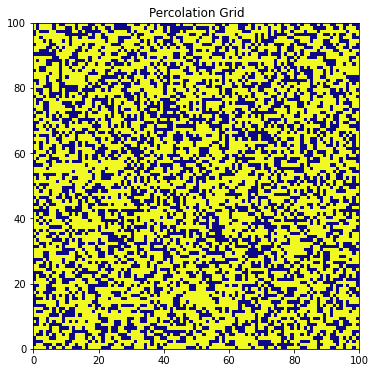

In [50]:
mygrid = generate_grid(100, 0.6)
display_grid(mygrid)

## Part 2 & 3 (core): Finding a Yellow Path From Left to Right on Our Grid

The function below is the most efficient way that we found to calculate the existence of a grid from left to right. Other methods including the use of memoization were found to be inefficient in terms of computation time. We loop over a list of coordinates which specify which squares we already know to be reachable, checking the neighbours of these coordinates each time, and assigning them to the list if they are also reachable. Initially we only find the reachable squares in the left hand column and then iterate over our list from there.

In [7]:
# This function finds and displays a path of yellow squares for an inputted 2d numpy array grid
def find_display_path(grid,show_path=False):
    '''
    For a numpy array of booleans (the yellow/blue grid), this function returns True or False
    depending on whether or not a yellow path exists from the left to the right edge.
    It will also display the path.
    '''
    
    # we find the size of the grid and initialise variables giving us the side lengths
    grid_size = np.shape(grid)
    x_length = grid_size[1]
    y_length = grid_size[0]
    # we make an array of the same size as the grid to store
    # which squares we can reach. Initially we assume we can't reach any
    # 0 represents a square is unreachable
    reachable = np.full(grid_size, 0)
    # 'yellows' is a list of arrays which contain the coordinates of each yellow square
    # Note that 'np.argwhere' find the index where the condition given is met
    yellows = np.argwhere(grid == True)
    
    # we store the x and y coordinates of the points in 'yellows' in seperate arrays within a larger array 'yellows_xy'
    # Note that '.T' transposes the array as described
    yellows_xy = np.array(yellows).T

    # we find the indices in the x coordinate array of each yellow in the left hand column of the grid
    # Note that 'np.where' find the elements that meet the condition given. In this case the elements are indices
    # because 'yellows_xy' is a an array of arrays of indices.
    indices = np.where(yellows_xy[1] == 0)

    # using the indices we found we now find the corresponding y coordinate of these yellow squares in the first column
    # we iterate over each index assigning 1 to reachable[y,0] where [y,0] is yellow.
    # 1 signifies a yellow reachable square in reachable while all currently unreached squares are 0
    for i in (indices[0]):
        reachable[yellows_xy[0][i], 0] = 1
    
    # We create an array of all coordinates of sites already checked in the form of a list of lists.
    # We use a list of lists here as it is quicker to loop over each element 
    # than it would be for a double loop of a 2D numpy array.
    reachable_list = np.asarray(np.where(reachable == 1)).T.tolist()

    # now we search for adjacent yellow squares to the ones we already have
    # we iterate over our list of coordinates of reachable squares.
    # we assign y and x for each squares so that we can later compare to adjacent sites
    for square in reachable_list:
        y = square[0]
        x = square[1]
        # As soon as a site on the RHS is shown to be reachable we return True
        if 1 in reachable[:,x_length-1]:
            # We display the grid with yellow squares those that we know to be reachable
            display_grid(reachable)
            return True
        # check adjacent
        # the first ifs in each part stops us getting index out of bounds errors
        # we check !=1 because otherwise we'd find the same squares again
        # and it would loop forever
        else:
            if x<x_length-1:
                #checks right
                if grid[y,x+1] == True and reachable[y,x+1] != 1:
                    reachable[y,x+1] = 1
                    reachable_list.append([y,x+1])
            if y-1>=0:
                #checks below
                if grid[y-1,x] == True and reachable[y-1,x] != 1:
                    reachable[y-1,x] = 1
                    reachable_list.append([y-1,x])
            if y<y_length-1:
                #checks above
                if grid[y+1,x] == True and reachable[y+1,x] != 1:
                    reachable[y+1,x] = 1
                    reachable_list.append([y+1,x])
            if x-1>=0:
                #checks left
                if grid[y,x-1] == True and reachable[y,x-1] != 1:
                    reachable[y,x-1] = 1
                    reachable_list.append([y,x-1])
    
    # We display the grid with yellow squares those that we know to be reachable
    display_grid(reachable)
    # Return False if no further reachable path is found and we have not reached the right hand side of the grid
    return False

Running the code below finds a path from the left hand side to the right hand side of the grid generated above. We display the reachable yellow squares that were checked while finding this path. The output is a Boolean value, True if there is a path and False otherwise.

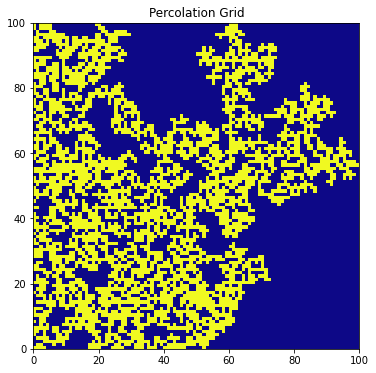

True

In [51]:
find_display_path(mygrid)

In [3]:
# For the sake of performance this function is not able to display the path but is otherwise the same as find_display_path.
# An 'if' statement with a verbose parameter checking whether or not to display the function was also found to be slower
# when computing a this function many times.
def find_path_across(grid):
    '''
    For a numpy array of booleans (the yellow/blue grid), this function returns True or False
    depending on whether or not a yellow path exists from the left to the right edge.
    '''
    
    # we find the size of the grid and initialise variables giving us the side lengths
    grid_size = np.shape(grid)
    x_length = grid_size[1]
    y_length = grid_size[0]
    # we make an array of the same size as the grid to store
    # which squares we can reach. Initially we assume we can't reach any
    # 0 represents a square is unreachable
    reachable = np.full(grid_size, 0)
    # 'yellows' is a list of arrays which contain the coordinates of each yellow square
    # Note that 'np.argwhere' find the index where the condition given is met
    yellows = np.argwhere(grid == True)
    
    # we store the x and y coordinates of the points in 'yellows' in seperate arrays within a larger array 'yellows_xy'
    # Note that '.T' transposes the array as described
    yellows_xy = np.array(yellows).T

    # we find the indices in the x coordinate array of each yellow in the left hand column of the grid
    # Note that 'np.where' find the elements that meet the condition given. In this case the elements are indices
    # because 'yellows_xy' is a an array of arrays of indices.
    indices = np.where(yellows_xy[1] == 0)

    # using the indices we found we now find the corresponding y coordinate of these yellow squares in the first column
    # we iterate over each index assigning 1 to reachable[y,0] where [y,0] is yellow.
    # 1 signifies a yellow reachable square in reachable while all currently unreached squares are 0
    for i in (indices[0]):
        reachable[yellows_xy[0][i], 0] = 1
    
    # we create an array of all coordinates of sites already checked in the form of a list of lists
    # We use a list of lists here as it is quicker to loop over each element 
    # than it would be for a double loop of a 2D numpy array.
    reachable_list = np.asarray(np.where(reachable == 1)).T.tolist()

    # now we search for adjacent yellow squares to the ones we already have
    # we iterate over our list of coordinates of reachable squares.
    # we assign y and x for each squares so that we can later compare to adjacent sites
    for square in reachable_list:
        y = square[0]
        x = square[1]
        # As soon as a site on the RHS is shown to be reachable we return True
        if 1 in reachable[:,x_length-1]:
            return True
        #check adjacent
        #the first ifs in each part stops us getting index out of bounds errors
        #we check !=1 because otherwise we'd find the same squares again
        #and it would loop forever
        else:
            if x<x_length-1:
                #checks right
                if grid[y,x+1] == True and reachable[y,x+1] != 1:
                    reachable[y,x+1] = 1
                    reachable_list.append([y,x+1])
            if y-1>=0:
                #checks below
                if grid[y-1,x] == True and reachable[y-1,x] != 1:
                    reachable[y-1,x] = 1
                    reachable_list.append([y-1,x])
            if y<y_length-1:
                #checks above
                if grid[y+1,x] == True and reachable[y+1,x] != 1:
                    reachable[y+1,x] = 1
                    reachable_list.append([y+1,x])
            if x-1>=0:
                #checks left
                if grid[y,x-1] == True and reachable[y,x-1] != 1:
                    reachable[y,x-1] = 1
                    reachable_list.append([y,x-1])
    
    # Return False if after no further reachable path is found and we have not reached the right hand side of the grid
    return False

The code below does the same as the `find_display_path` function but does not display the path. It only returns the Boolean output checking whether a path exists.

In [15]:
find_path_across(mygrid)

True

As we can see from the tests below it is faster to not display the grid so for our computationally intensive plots below we will not use a function that displays the grid everytime.

In [16]:
%timeit find_path_across(mygrid)

37.5 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


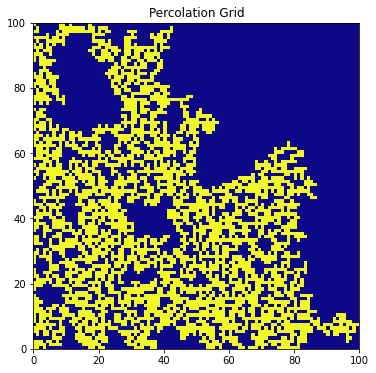

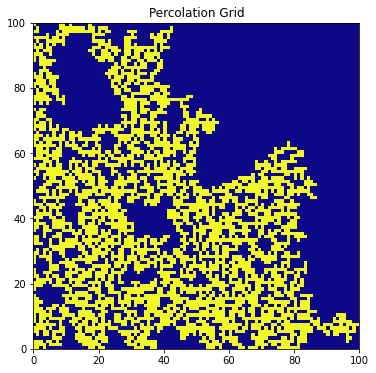

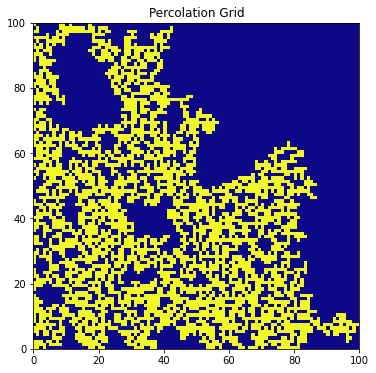

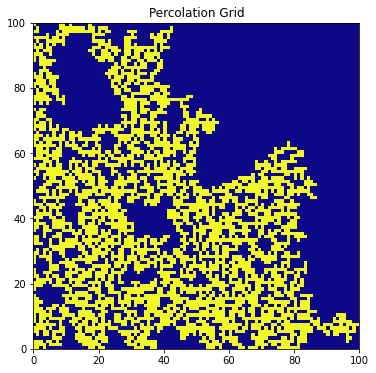

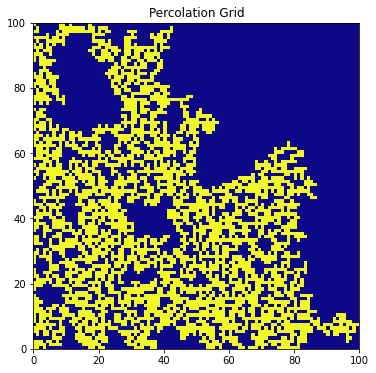

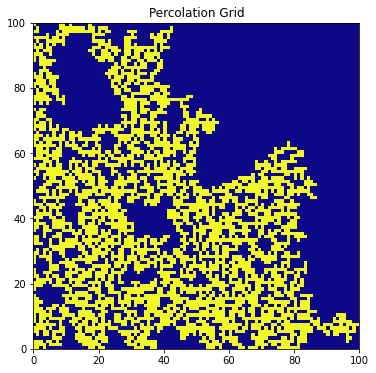

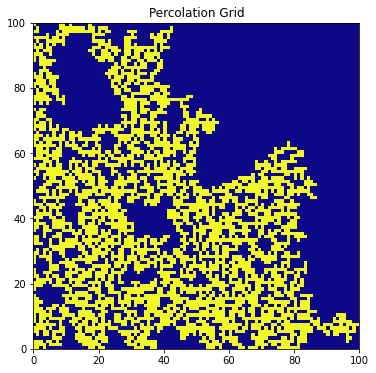

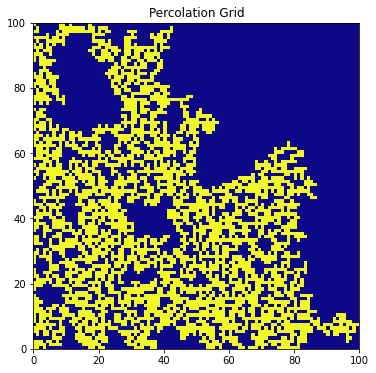

387 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit find_display_path(mygrid)

### Real-life Applications of Percolation

Percolation is applicable to many real-life situations—the flow of liquid through porous material or electricity through a conductor, among others. One interesting application of percolation we found was in neural networks. As proposed here [Zhukov, Samoylo, Brooks and Hodges, 2016], the formatting of neural networks for pattern recognition in the brain can be modelled as a percolation problem. This model equates neurons on a subnet to “knobs” in a graph, which in our case is squares on a grid. If a ‘path’ is found between squares on either side of the grid, then this is equivalent to a chain of neurons forming between the input and output layers of a network in the brain.  Visualising our simple grid model as a real-life process helps us to understand the aims of percolation theory.

## Part 4 (core): Finding the Limit $F(p) = \lim_{n\to\infty} F_n(p)$ and Estimating the Critical Point $P_c$

For a grid of size $n\times n$ and a probability of yellow squares $p$, we define:

<p style="text-align: center;"> $F_n(p) = \mathbb{P}$(there is a yellow path connecting the left and right sides of the grid). </p>

The function below estimates this probability for a given $n$, $p$ and number of trials. We also pass an argument `grid_type` to be used later.
We are most interested in $F(p) = \lim_{n\to\infty} F_n(p)$ as we can then define our critical point $P_c$ to be as follows:

<p style="text-align: center;">
$F(p) = \begin{cases}
0, & p < p_c\\
1, & p > p_c
\end{cases}$ </p>

In [22]:
def Fn(trials, n, p, grid_type):
    '''
    This function finds Fn (the probability of a path from left to right) for a given grid size and probability of yellows.
    This is an estimate based on the number of successful vs unsuccessful trials.
    '''
    # we initialise a count function to note the trials which succeed in finding a path
    count = 0
    
    # we iterate 'trials' number of times, each time creating a grid and checking whether there is a path from left to right
    for i in range(trials):
        grid = grid_type(n, p)
        # when there is a path we increase 'count' by 1
        if find_path_across(grid):
            count += 1
    # we return the probability of finding a path, the number of successful trials divided by the total number of trials
    return 1.0 * count/trials

The function below plots a graph of $F_n$ for given $n$ against probabilities $p$ in the range $[0.5, 0.7]$.\
We are using this range as we expect that to $2$ d.p., $P_c$ will be $0.59$ [Christensen, 2002].
Our first attempt at estimating $P_c$ is to find the probability on the $x$-axis which corresponds to $F_n = 0.5$ on the $y$-axis through interpolation. This appears to be a sensible method given that we know, for sufficiently large $n$, $F_n$ should be evenly distrubuted (as either $0$ or $1$) either side of the percolation threshold $P_c$. Another advantage of this method, unlike the two methods we will attempt next, is that we can achieve greater precision through interpolation without having to compute $10$ times as many probabilities for an extra decimal place. Unfortunately, the accuracy of the interpolated result at greater decimal places when only actually computing probabilities to $2$ d.p. is unknown. As a result we only use a precision of $3$ d.p. when displaying our estimate since we can be confident the estimate lies between the probabilites we have calculated.

In [5]:
# This function plots Fn against the yellow probabilities for 3 grid sizes
# It also finds an estimate of Pc by finding the interpolated x value corresponding to y=0.5
def Pc_at_0_5(trials, n1, n2, n3, grid_type):
    
    # We find Fn at all 3 n's for 20 equally spaced probabilities between 0.5 and 0.7
    x_vals = np.linspace(0.5, 0.7, 20)
    y_vals1 = np.array([Fn(trials, n1, p, grid_type) for p in x_vals])
    y_vals2 = np.array([Fn(trials, n2, p, grid_type) for p in x_vals])
    y_vals3 = np.array([Fn(trials, n3, p, grid_type) for p in x_vals])
    
    # Our estimate for Pc using the x value corresponding to y=0.5
    Pc = np.interp(0.5, y_vals1, x_vals)
    
    # Plot of all three curves of Fn and our estimate of Pc
    plt.plot(x_vals, y_vals1, color='green', label=f'$n={n1}$')
    plt.plot(x_vals, y_vals2, color='blue', label=f'$n={n2}$')
    plt.plot(x_vals, y_vals3, color='cyan', label=f'$n={n3}$')
    plt.plot(Pc, 0.5, 'o', color = 'green')
    plt.text(Pc+0.018, 0.5, f"$P_c = {Pc:.3f}$", ha="center")
    plt.axvline(Pc, ls='--')
    plt.xlabel("Probability of Yellow Squares")
    plt.ylabel("Probability of Percolation")
    plt.title(f"Probability of Percolation for n = {n1}, {n2} & {n3}")
    plt.legend()

Below we see the plot of $F_n$ for $n=500$, $200$ & $100$ with a marked estimate (using the method described above) of $P_c$ to $3$ d.p.. We do $100$ trials at each probability.

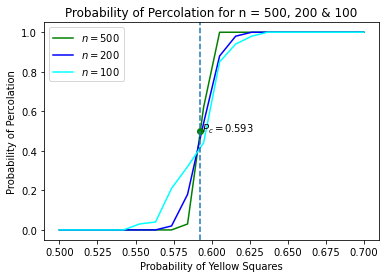

In [6]:
Pc_at_0_5(100, 500, 200, 100, generate_grid)

Again we plot $F_n$, but in this case to estimate $P_c$ we find the probability corresponding to the value of $F_n$ at which there was the greatest increase for the next probability.

In [31]:
# This function plots Fn against the yellow probabilities for 3 grid sizes
# It also finds an estimate of Pc by finding the greatest gradient between values of Fn
# i.e. where the probability of a path from left to right changes the most
# We specify a function parameter for later use with a different function
def greatest_gradient_Pc(trials, n1, n2, n3, grid_type, func):
    
    # We find Fn (or Gn) at all 3 n's for 20 equally spaced probabilities between 0.5 and 0.7
    if func == Fn_triangles:
        x_vals = np.linspace(0.45, 0.55, 10)
    # This case is for use with the function 'Fn_triangles' later. Uses 10 equally spaced probabilities.
    else:
        x_vals = np.linspace(0.5, 0.7, 20) 
        
    y_vals1 = np.array([func(trials, n1, p, grid_type) for p in x_vals])
    y_vals2 = np.array([func(trials, n2, p, grid_type) for p in x_vals])
    y_vals3 = np.array([func(trials, n3, p, grid_type) for p in x_vals])
    
    # We find the index of the yellow probability at which there is the greatest increase in Fn
    # This is the index of our estimate of Pc in this function.
    # Note that 'np.argmax' returns the index of the maximum value of the array in the brackets
    Pc_idx = np.argmax(y_vals1[1:] - y_vals1[:-1])
    
    # Plot of all three curves of Fn and our estimate of Pc
    plt.plot(x_vals, y_vals1, color='green', label=f'$n={n1}$')
    plt.plot(x_vals, y_vals2, color='blue', label=f'$n={n2}$')
    plt.plot(x_vals, y_vals3, color='cyan', label=f'$n={n3}$')
    plt.plot(x_vals[Pc_idx], y_vals1[Pc_idx],'o', color = 'green')
    plt.text(x_vals[Pc_idx]+0.018, y_vals1[Pc_idx], f"$P_c = {x_vals[Pc_idx]:.2f}$", ha="center")
    plt.axvline(x_vals[Pc_idx], ls='--')
    plt.xlabel("Probability of Yellow")
    plt.ylabel("Probability of Percolation")
    plt.title(f"Probability of Percolation for n = {n1}, {n2} & {n3}")
    plt.legend()

Below is the $F_n$ plot as before but using our new method of estimating $P_c$. Here we get an estimate of $0.58$, $0.01$ lower than we expected, perhaps skewed by the fact that we had some outlier results at $0.58$ and $0.59$. This makes logical sense given that for large $n$ we expect a horizontal line at $P_c$, indicating the greatest change in the gradient. However, for the values of $n$ (and the number of samples at each of those $n$'s) that we are able to compute, this method of estimating is susceptible to outliers and so may not be the most accurate.

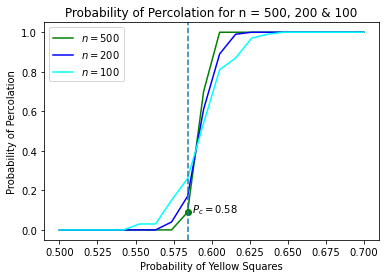

In [23]:
greatest_gradient_Pc(100, 500, 200, 100, generate_grid, Fn)

Our next method for estimating $P_c$ uses the intercept of the $F_n$ curves for the two largest $n$'s that we plot.

In [9]:
# This function plots Fn against the yellow probabilities for 3 grid sizes
# It also finds an estimate of Pc by finding the the intercept of the two Fn curves with the greatest n
def intercept_Pc(trials, n1, n2, n3, grid_type):
    
    # We find Fn at all 3 n's for 20 equally spaced probabilities between 0.5 and 0.7.
    x_vals = np.linspace(0.5, 0.7, 20)
    y_vals1 = np.array([Fn(trials, n1, p, grid_type) for p in x_vals])
    y_vals2 = np.array([Fn(trials, n2, p, grid_type) for p in x_vals])
    y_vals3 = np.array([Fn(trials, n3, p, grid_type) for p in x_vals])
    
    # We create two interpolated splines to fit the values of Fn to smooth curves
    # Here we use 'InterpolatedUnivariateSpline' method of scipy.interpolate to create these based on two of
    # the x and y value arrays that we have plotted.
    spline1 = inter.InterpolatedUnivariateSpline(x_vals, y_vals1)
    spline2 = inter.InterpolatedUnivariateSpline(x_vals, y_vals2)
    
    # This function finds the value of the difference between our two splines at a given point x
    def difference(x):
        return spline1(x) - spline2(x)
    
    # We use the 'brentq' method of scipy.optimize to find the roots of our difference function in the region [0.58,0.60].
    # The roots of this function are when our two splines are equal - the intercept of the two.
    # This is our estimate for Pc.
    intercept = opt.brentq(difference, 0.58, 0.6)
    
    # Plot of all three curves of Fn and our estimate of Pc
    plt.plot(x_vals, y_vals1, color='green', label=f'$n={n1}$')
    plt.plot(x_vals, y_vals2, color='blue', label=f'$n={n2}$')
    plt.plot(x_vals, y_vals3, color='cyan', label=f'$n={n3}$')
    plt.plot(intercept, spline1(intercept),'o', color = 'green')
    plt.text(intercept+0.018, spline1(intercept), f"$P_c = {intercept:.2f}$", ha="center")
    plt.axvline(intercept, ls='--')
    plt.xlabel("Probability of Yellow Squares")
    plt.ylabel("Probability of Percolation")
    plt.title(f"Probability of Percolation for n = {n1}, {n2} & {n3}")
    plt.legend()

Below is an estimate of $P_c$ using the new method above. We can see that for our values of $n$ this appears to be a very accurate method and the interception points are all very close together. A problem with this method is that we are always relying on a smaller $n$ than the maximum one we have computed to give our estimate. For example, in the plot below, the estimate is partly based on the plot of $n=200$ rather than just on $n=500$ but the percolation threshold behaviour is defined for $n\to\infty$ so using smaller $n$ should give us worse accuracy.

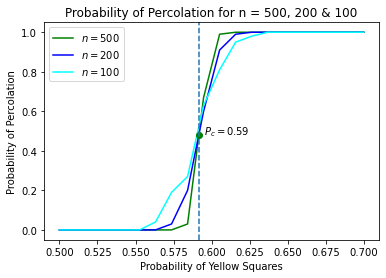

In [58]:
intercept_Pc(100, 500, 200, 100, generate_grid)

## Part 5 (further): Rectangular Grids of Sizes $2n \times n$ & $3n \times 2n$

We now want to generate grids of different sizes. The below functions create yellow and blue grids of sizes $2n\times n$ and $3n\times 2n$

In [10]:
# generate a 2n by n grid
def generate_2nxn(n, p_yellow):
    
    colours = np.random.rand(n, 2*n)  # Initialise 2d array of random numbers between 0 and 1
    colours = colours < p_yellow  # Sets each cell to True if it's less than p_yellow, else False.
    return colours

# generate a 3n by 2n grid
def generate_3nx2n(n, p_yellow):
    
    colours = np.random.rand(2*n, 3*n)  # Initialise 2d array of random numbers between 0 and 1
    colours = colours < p_yellow  # Sets each cell to True if it's less than p_yellow, else False.
    return colours

We can see these grids below:

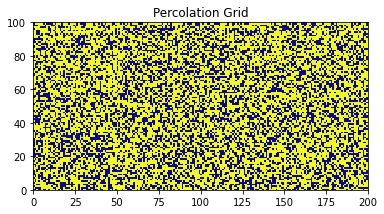

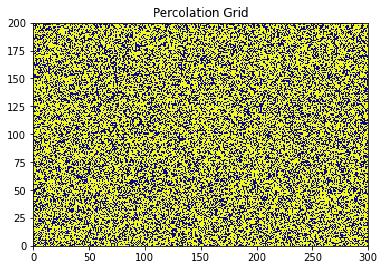

In [33]:
grid_2nxn = generate_2nxn(100, 0.6)

grid_3nx2n = generate_3nx2n(100, 0.6)

display_grid(grid_2nxn)

display_grid(grid_3nx2n)

We will now estimate $P_c$ again but this time for a path from left to right on these recatangular grids. As you can see from the plots below our estimate is the same to $2$ d.p. using the `intercept_Pc` function. Here the parameter `grid_type` is useful as we can change the shape of our generated grids. The gradients are not quite as steep or identically distributed here as they were for $n \times n$ grids so the `greatest_gradient_Pc` and `Pc_at_0_5` methods are less accurate estimations.

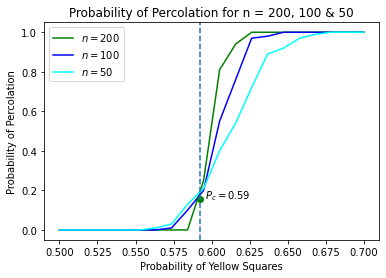

In [24]:
intercept_Pc(100, 200, 100, 50, generate_2nxn)

For a $3n \times 2n$ grid the gradients are steep and so the `greatest_gradient_Pc` method may be equally accurate but given we are using even smaller $n$ here it may also be more prone to outliers. The `Pc_at_0_5` method is unlikely to be accurate given the distributions do not appear anywhere near as identical either side of the threshold as they were for $n \times n$ grids and this could be in part due to the fact we are computing smaller $n$ than before.

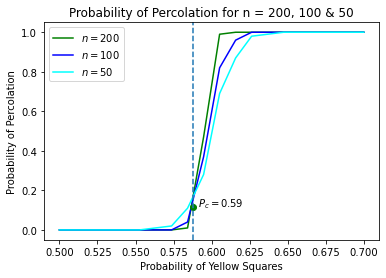

In [23]:
intercept_Pc(100, 200, 100, 50, generate_3nx2n)

## Part 6 (Self Created Task): Binary Search - Faster, high precision estimate of $P_c$

We also decided to attempt to find a quicker way to estimate $P_c$ with much higher precision. Previously we were only able to estimate $P_c$ to $2$ decimal places since the computation time increases significantly for more decimal places. With our binary search method below which repeatedly halves the possible range of $P_c$, we can quickly estimate it to many decimal places.

In [10]:
# This function allows us to reduce the range in which we know the critical point lies
def narrow_range(lower, upper, grid):
    # We first find the midpoint of lower and upper
    mid = lower + (upper-lower)/2
    # We set the probability of yellow squares on the grid to mid
    grid = grid < mid
    # We check if a path from left to right was found, if so then we reduce upper to mid, narrowing the range from above.
    # This is because if a path was found then we are very likely to be over the critical point at mid.
    # If no path was found then we increase lower to mid as we are very likely to be below the critical point at mid.
    if find_path_across(grid):
        upper = mid
    else:
        lower = mid
    # Finally we return the new values of lower and upper to be used once for the next call to the function.
    return lower, upper


# This function only works on a grid of uniformly random numbers, not booleans. It attempts to find the critical point.
def find_crit_point(grid, iterations):
    # We know from testing that the critical point was somewhere around 0.59, definitely between 0.55 and 0.65
    # so our first upper and lower bounds will be those, and we will shrink it down by iteratively calling 'narrow_range'
    # 'iterations' represents how many times we have narrowed our range. 
    lower = 0.55
    upper = 0.65
    for i in range(0, iterations):
        lower, upper = narrow_range(lower, upper, grid)
    
    # Finally we return the the midpoint after our iterations of 'narrow_range' are complete
    return lower + (upper-lower)/2

# This function gives us the result of each sample of 'find_crit_point' 
# and the final estimate which is an average of the samples.
def test_crit_points(samples, gridsize, iterations, outliers = False):
    # We initialise a numpy array of sample many zeros to store the results of the samples
    results = np.zeros(samples)
    # We then loop sample many times, each time for a new random grid of the given grid size.
    # We run 'find_crit_point' on these grids and store the result in the numpy array
    for i in range(samples):
        grid = generate_grid(gridsize, 0)
        results[i] = find_crit_point(grid, iterations)
    
    # We also want to remove outliers from these estimates of Pc. We will use the 1.5 times the IQR method of identifying
    # outliers so our reuslts are more accurate. 
    if outliers == True:
        # We have used the 'iqr' method from scipy.stats to calculate the iqr.
        IQR = iqr(results, rng=(25,75), interpolation='midpoint')
        # We then set bounds by finding the 25th and 75th percentile and calculating (1.5*IQR) below and above these values.
        lower_bound = (np.percentile(results, 25, interpolation='midpoint') - 1.5*(IQR))
        upper_bound = (np.percentile(results, 75, interpolation='midpoint') + 1.5*(IQR))
        # To remove the outliers from our results we use boolean indexing and only
        # include values in the range [lower_bound, upper_bound]. This gives us our new results array without outliers.
        results = results[(results >= lower_bound) & (results <= upper_bound)]
    
    # Finally we average the results with outliers removed, giving us an estimate
    # We then return both the new results array and the estimate
    estimate = np.average(results)
    return results, estimate

Running `test_crit_points` $20$ times on a $1000 \times 1000$ grid we get an estimate and an array of the non-outlier results of each sample. We expect the estimate to be accurate to around $4$ d.p as we have halved the range $13$ times so we are hopefully calculating with accuracy to $\frac{1}{2^{13}} = 0.000122...$. Our estimate turns out to be around $0.0015$ out from what expect but running this with more samples and a larger grid would hopefully improve the accuracy.

In [30]:
test_crit_points(20, 1000, 13, True)

(array([0.5895813 , 0.59286499, 0.5989563 , 0.58956909, 0.60131226,
        0.596698  , 0.60254517, 0.59037476, 0.59317017, 0.59514771,
        0.59328003, 0.59144897, 0.59553833, 0.5940979 , 0.59602661,
        0.58999634, 0.59627075, 0.5946106 , 0.5894104 , 0.59338989]),
 0.5942144775390626)

It is interesting to see the distribution of these results through both scatter and box plots rather than just an array. The functions below allow us to do this.

In [36]:
# This plots a scatter diagram of the results array
def plot_test_results_scatter(samples, gridsize, iterations, outliers):
    results, estimate = test_crit_points(samples, gridsize, iterations, outliers)
    plt.scatter(np.arange(0, len(results), 1), np.sort(results))
    plt.hlines(estimate, 0, len(results), colors="r", ls='--', lw=0.7)
    plt.text(0, estimate, f"{estimate:.4f}", color='r', ha="left", va="bottom")
    plt.title(f'Scatter Plot of {samples} Samples of Pc for Grid Size {gridsize}')
    plt.xlabel('Sample')
    plt.ylabel('Critical Point Estimate - Pc')
    plt.plot()
    plt.show()

# This plots a box plot of the results array for different grid sizes. We can see that variance decreases as the grid size
# increases. Also, the mean of results is nearer the expected P_c value for larger grids than for smaller.
def plot_test_results_boxes():
    results_10 = test_crit_points(100, 10, 12, False)[0]
    results_50 = test_crit_points(100, 50, 12, False)[0]
    results_200 = test_crit_points(100, 200, 12, False)[0]
    plt.boxplot([results_10, results_50, results_200], labels=['n = 10', 'n = 50', 'n = 200'])
    plt.title('Box plot of Critical Points Estimates for Grid Size n')
    plt.ylabel('Critical Point Results - Pc')
    plt.plot()
    plt.show()

Plotting the scatter diagram we can see that, for $200$ samples on a grid size of $500$, our estimate precise to $4$ d.p., is accurate to within $0.0004$. We are displaying the result to $4$ d.p. due to the accuracy of using $13$ iterations as mentioned above.

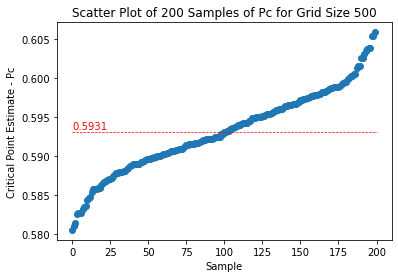

In [40]:
plot_test_results_scatter(200, 500, 13, True)

The box plot below allows us to see how, as we increase the grid size, the variance of the results is greatly diminished. This may lead to a few outliers that we can remove from our estimate so it is more accurate.

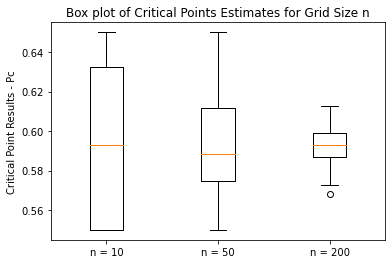

In [37]:
plot_test_results_boxes()

## Part 7 (further): Investigating $G_n(p)$ - the Probability of a Path from the Centre of the Grid to the Boundary

We will now look at new probability $G_n(p)$ defined as follows:

<p style="text-align: center;"> $G_n(p) = \mathbb{P}$(there is a yellow path connecting the centre of the grid to the boundary) </p>
    
Its limit is then $G(p) = \lim_{n\to\infty} G_n(p)$.

In [16]:
# This function finds a yellow path from the centre square to the boundary of the grid
def path_from_centre(grid):
    
    # we find the size of the grid and initialise variables giving us the side lengths
    grid_size = np.shape(grid)
    x_length = grid_size[1]
    y_length = grid_size[0]
    #we make an array of the same size as the grid to store
    #which squares we can reach. Initially we assume we can't reach any
    #0 represents a square is unreachable
    reachable = np.full(grid_size, 0)
    
    # 'yellows' is a list of arrays which contain the coordinates of each yellow square
    yellows = np.argwhere(grid == True)

    # The coordinates of the square in the centre of the grid.
    # If the grid has even length sides then there is no exact centre so we use a nearest square
    centre = ((y_length+1)//2, (x_length+1)//2)
    
    # If the centre of the grid is yellow then we assign 1 to it's position in reachable
    # and update our array of reachable squares. Otherwise we return False immediately
    if centre in yellows:
        reachable[centre] = 1
        reachable_array = np.asarray(np.where(reachable == 1)).T.tolist()
    else:
        return False
    
    # # now we search for adjacent yellow squares to the ones we already have
    # we iterate over our array of coordinates of reachable squares.
    for square in reachable_array:

        # we assign y and x for each squares so that we can later compare to adjacent sites
        y = square[0]
        x = square[1]

        # We define the boundary as the combination of the columns and rows at the edges of the grid
        boundary = np.concatenate((reachable[:,x_length-1], reachable[:,0], reachable[0,:], reachable[y_length-1,:]))

        # As soon as a site on the RHS is shown to be reachable we return True
        if 1 in boundary:
            #display_grid(reachable)
            return True
        #check adjacent
        #the first ifs in each part stops us getting index out of bounds errors
        #we check !=1 because otherwise we'd find the same squares again
        #and it would loop forever
        else:
            if x<x_length-1:
                #checks right
                if grid[y,x+1] == True and reachable[y,x+1] != 1:
                    reachable[y,x+1] = 1
                    reachable_array.append([y,x+1])
            if y-1>=0:
                #checks below
                if grid[y-1,x] == True and reachable[y-1,x] != 1:
                    reachable[y-1,x] = 1
                    reachable_array.append([y-1,x])
            if y<y_length-1:
                #checks above
                if grid[y+1,x] == True and reachable[y+1,x] != 1:
                    reachable[y+1,x] = 1
                    reachable_array.append([y+1,x])
            if x-1>=0:
                #checks left
                if grid[y,x-1] == True and reachable[y,x-1] != 1:
                    reachable[y,x-1] = 1
                    reachable_array.append([y,x-1])
    #display_grid(reachable)
    return False

Below we find a path from the centre square to the boundary, using a square grid with odd length sides and displaying the squares that we checked to be reachable during this process.

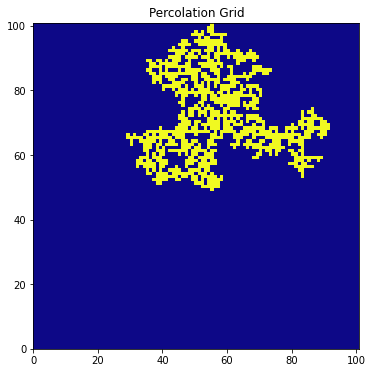

True

In [39]:
odd_grid = generate_grid(101, 0.6)

path_from_centre(odd_grid)

The two cells below show that finding a path from the centre to the boundary is quicker than from the left to the right. This is because there are four sides to reach. In this case there was a path for `odd_grid` but if we run our this on new grids each time our performance results will be slightly skewed by the fact that if the centre square is generated as blue then `path_from_centre` immediately returns False, meaning no computation of the path is required.

In [42]:
%timeit path_from_centre(odd_grid)

32.5 ms ± 2.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
%timeit find_path_across(odd_grid)

108 ms ± 12.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We would also like to explore the critical point for a path connecting the centre of the grid to the boundary.

In [29]:
# Note this function is identical to 'Fn' except that it uses 'path_from_centre' rather than 'find_path_across'.
# We haven't changed to parameters of 'Fn' to take 'path_from_centre' because we want to call this function 'In' so that
# it is clear it refers to the probability defined directly above and not the probability 'Fn' defined earlier.
def Gn(trials, n, p, grid_type):
    '''
    This function finds Gn for a given grid size and probability of yellows.
    This is an estimate based on the number of successful vs unsuccessful trials.
    '''
    # we initialise a count function to note the trials which succeed in finding a path
    count = 0
    
    # we iterate 'trials' number of times, each time creating a grid and checking whether there is a path from 
    # the centre to the boundary
    for i in range(trials):
        grid = grid_type(n, p)
        # when there is a path we increase 'count' by 1
        if path_from_centre(grid):
            count += 1
    # we return the probability of finding a path, the number of successful trials divided by the total number of trials
    return 1.0 * count/trials

Using `greatest_gradient_Pc` we estimate $P_c$ to $2$ d.p. such that:

<p style="text-align: center;"> $G(p) = \begin{cases}
0, & p < P_c\\
1, & p > P_c
\end{cases}$ , </p>

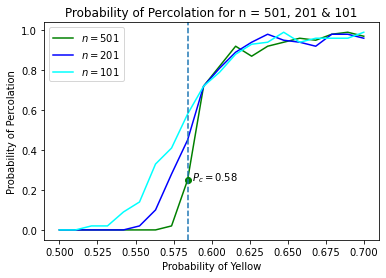

In [32]:
greatest_gradient_Pc(100, 501, 201, 101, generate_grid, Gn)

As you can see from the plot above, the 'critical point' $P_c$ for percolation from the centre to the boundary appears to be the same as from left to right. However, it is not exactly a critical point since this is the point at which the probability of percolation increases the most but not immediately to $1$. As a result we used `greatest_gradient_Pc` here so our estimate shows the point of greatest increase. The behaviour is also exactly the same as left to right for small $p$ where the probability of percolation is always $0$. However, it differs from left to right percolation because at values of $p$ only slightly greater than the critical point we do not see it always percolate with probability $1$. This is because of the chance that it immediately fails with probability $1 - p$ if the centre square is blue. Obviously as $p \to 1$ this becomes increasingly unlikely but for $p = 0.6$, which is only slightly above $P_c$, we expect to see percolation only occur about $80\%$ of the time compared to almost $100\%$ of the time for left to right percolation.

## Part 8 (further): Triangular Lattice

In this section we look at $F_n(p)$ as before but with a triangular lattice: equilateral triangles with six triangles meeting at each site. This time the sites are vertices, not faces, and adjacent vertices are those joined by edges. We implement this (as suggested) with a square grid again, but with $x+(1,1)$ considered reachable by $x$, with the set up staying otherwise the same.
Even though this was suggested, we motivate it's use later in this section as it felt incomplete without it.

First we implement this on the square grid generated by `generate_grid` and working left to right, before worrying about what overall shape we're actually looking at.
Modifying `find_path_across` to search x + (1,1) too:

In [12]:
def find_path_across_triangles(grid):
    '''
    For a numpy array of booleans (the yellow/blue grid), this function returns True or False
    depending on whether or not a yellow path exists from the left to the right edge. This interprets
    the square grid as a triangular lattice.
    '''
    
    # we find the size of the grid and initialise variables giving us the side lengths
    grid_size = np.shape(grid)
    x_length = grid_size[1]
    y_length = grid_size[0]
    # we make an array of the same size as the grid to store
    # which squares we can reach. Initially we assume we can't reach any
    # 0 represents a square is unreachable
    reachable = np.full(grid_size, 0)
    # 'yellows' is a list of arrays which contain the coordinates of each yellow square
    yellows = np.argwhere(grid == True)
    
    # we store the x and y coordinates of the points in 'yellows' in seperate arrays within a larger array 'yellows_xy'
    yellows_xy = np.array(yellows).T

    # we find the indices in the x coordinate array of each yellow in the left hand column of the grid
    indices = np.where(yellows_xy[1] == 0)

    # using the indices we found we now find the corresponding y coordinate of these yellow squares in the first column
    # we iterate over each index assigning 1 to reachable[y,0] where [y,0] is yellow.
    # 1 signifies a yellow reachable square in reachable while all currently unreached squares are 0
    for i in (indices[0]):
        reachable[yellows_xy[0][i], 0] = 1
    
    # we create a list of all coordinates of sites already checked in the form of a list of lists
    reachable_list = np.asarray(np.where(reachable == 1)).T.tolist()

    # now we search for adjacent yellow squares to the ones we already have and x+(1,1)
    # we iterate over our array of coordinates of reachable squares.
    # we assign y and x for each squares so that we can later compare to adjacent sites
    for square in reachable_list:
        y = square[0]
        x = square[1]
        # As soon as a site on the RHS is shown to be reachable we return True
        if 1 in reachable[:,x_length-1]:
            return True
        #check adjacent
        #the first ifs in each part stops us getting index out of bounds errors
        #we check !=1 because otherwise we'd find the same squares again
        #and it would loop forever
        else:
            if x<x_length-1:
                #checks right
                if grid[y,x+1] == True and reachable[y,x+1] != 1:
                    reachable[y,x+1] = 1
                    reachable_list.append([y,x+1])
            if y-1>=0:
                #checks below
                if grid[y-1,x] == True and reachable[y-1,x] != 1:
                    reachable[y-1,x] = 1
                    reachable_list.append([y-1,x])
            if y<y_length-1:
                #checks above
                if grid[y+1,x] == True and reachable[y+1,x] != 1:
                    reachable[y+1,x] = 1
                    reachable_list.append([y+1,x])
            if x-1>=0:
                #checks left
                if grid[y,x-1] == True and reachable[y,x-1] != 1:
                    reachable[y,x-1] = 1
                    reachable_list.append([y,x-1])
            if y-1>=0 and x<x_length-1:
                #checks x+(1,1)
                #because it's an array, and increase in y is actually lower
                # so [y-1,x+1] corresponds to *x*+(1,1) in cartesian coordinates
                #this is the only bit that's different
                if grid[y-1,x+1] == True and reachable[y-1,x+1] !=1:
                    reachable[y-1,x+1] = 1
                    reachable_list.append([y-1,x+1])
                         
    
    # Return False if after no further reachable path is found and we have not reached the right hand side of the grid
    return False

We also modify the tests from before to estimate $F_n(p)$

In [10]:
def Fn_triangles(trials, n, p, grid_type):
    '''
    This function finds Fn (the probability of a path from left to right) for a given grid size and probability of yellows.
    This is an estimate based on the number of successful vs unsuccessful trials.
    '''
    # we initialise a count function to note the trials which succeed in finding a path
    count = 0
    
    # we iterate 'trials' number of times, each time creating a grid and checking whether there is a path from left to right
    for i in range(trials):
        grid = grid_type(n, p)
        # when there is a path we increase 'count' by 1
        #here is the only difference
        if find_path_across_triangles(grid):
            count += 1
    # we return the probability of finding a path, the number of successful trials divided by the total number of trials
    return 1.0 * count/trials

When making `greatest_gradient_Pc` we added a parameter for a function so that we could later use change the function from `Fn`
to `Fn_triangles` here. We found the `greatest_gradient_Pc` method to be the most accurate estimation method for
a triangular lattice when comparing against the results found here [Christensen, 2002]. The code below plots $F_n$ for our new model, giving an estimate of $P_c$.

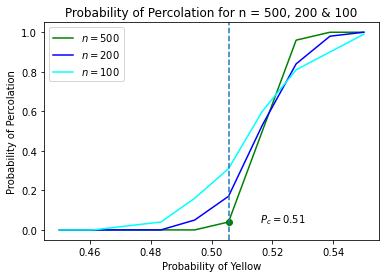

In [20]:
greatest_gradient_Pc(100, 500, 200, 100, generate_grid, Fn_triangles)

Given we were expecting $P_c = 0.5$, our estimate being within $0.01$ seems to suggest that this method of searching is equivalent and perhaps we could get a more accurate result using $n=1000$. However, looking at the square grid used to model the triangular lattice, it's not always obvious whether or not there is a path or why this method works. The next section motivates this. 

Note that the code isn't annotated because it's only visuals that are relevant here.

### Motivation

We start with a simple $3 \times 3$ grid and show how we get to the triangular lattice.<br>
First, instead of thinking of the sites as the faces of the squares, we instead (but equivalently) assign each site to be the bottom left corner of each square, as demonstrated below:

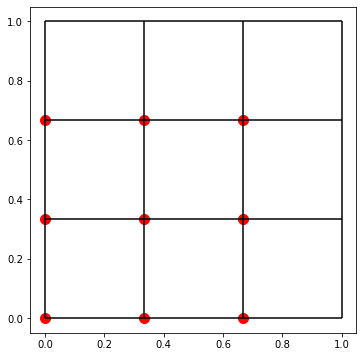

In [22]:
def sqgrid(c,k,zoom=False,diags=False):
    
    plt.figure(figsize=(6,6))
    plt.hlines(y=0,xmin=0,xmax=1,color=c)
    plt.hlines(y=1/3,xmin=0,xmax=1,color=c)
    plt.hlines(y=2/3,xmin=0,xmax=1,color=c)
    plt.hlines(y=1,xmin=0,xmax=1,color=c)
    plt.vlines(x=0,ymin=0,ymax=1,color=c)
    plt.vlines(x=1/3,ymin=0,ymax=1,color=c)
    plt.vlines(x=2/3,ymin=0,ymax=1,color=c)
    plt.vlines(x=1,ymin=0,ymax=1,color=c)
    xvals = [0,1/3,2/3]
    y1=[0]*3
    y2=[1/3]*3
    y3=[2/3]*3
    plt.scatter(xvals*3,y1+y2+y3,color=k,s=100)
    
    if zoom==True:
        plt.ylim(-0.01,2/3+0.01)
        plt.xlim(-0.01,2/3+0.01)

        plt.plot([0,1/3],[1/3,2/3],color=c)
        plt.plot([0,1],[0,1],color=c)
        plt.plot([1/3,2/3],[0,1/3],color=c)
    plt.gca().set_aspect('equal')
    plt.plot()
    return None


sqgrid('k','r')

Now we have uniquely defined each face of the square by it's bottom left vertex, and we have the new rule of being able to reach $x + (1,1)$, let's trace every path from every vertex, zooming in to only see the sites we've defined

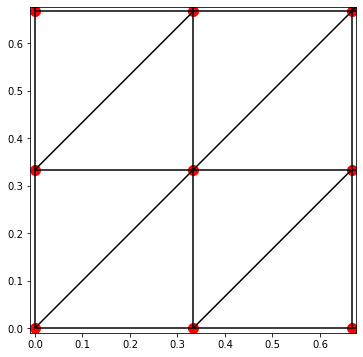

In [23]:
sqgrid('k','r',True)

This shows that the two ways of looking at it really are equivalent. You can see the six triangles meeting at a point in the centre of the grid and it's clear how it would tile the plane. The fact that these aren't equilateral triangles doesn't change the connections between them.

## Part 9 (Advanced): Parrallel Wires Percolation Model with Poisson Break and Connection Rates

The code below attempts to compute the following percolation model:
* We have infinitely many equally spaced parallel wires.
* Each wire has breaks according to a Poisson process. 
* Each adjacent pair of wires has bridges connecting them according to a Poisson process.
* The spacing of the wires is a function of the Poisson break rate

In [3]:
# function to create the breaks and connections lists using the rest of the data
def create_wires(height, num_wires, poisson_breaks, poisson_connections):
    
    # number of wires to apply breaks to
    n_breaks = num_wires - 2
    # number of wires to apply connections to
    n_connections = n_breaks + 1
    # this section creates list of breaks in wires
    # initializes a list of empty lists required for each wire
    breaks = [[] for x in range(n_breaks)]
    # for each of the wires except the first and last (since breaks in those wouldn't matter)
    for i in range(0, n_breaks):
        # get a running total starting at 0 (representing the bottom of the wire)
        total = 0
        # until we pass the top of the wire
        while total < height:
            # get a random exponential as the gap between the previous break and the next one
            gap = np.random.exponential(poisson_breaks)
            # add it to the total
            total += gap
            # if you're still on the wire
            if total < height:
                # add the y coord of the break to the list
                breaks[i].append(total)

    # some notes:
    # We don't add breaks in the first or last wires as the whole first wire is powered anyway and therefore adding
    # breaks wouldn't change anything, and in the last wire, we only care if any point of it is powered.
    # Also, while it seems pointless to check if total < height again inside the while loop, if I didn't do that then
    # it would add an extra break to the list that would be greater than the height. I could fix this by then removing
    # the last one afterwards, but that would make the code less readable (although slightly more efficient).

    # this section creates list of connections between wires
    # initializes a list of empty lists required for each wire
    connections = [[] for x in range(n_connections)]
    # for each gap between the wires (so number of wires - 1)
    for i in range(0, n_connections):
        # make running total
        total = 0
        # very similar to the previous one
        while total < height:
            gap = np.random.exponential(poisson_connections)
            total += gap
            if total < height:
                connections[i].append(total)

    return breaks, connections

In [4]:
# function to draw the wires and breaks on a graph using the breaks and connections
def draw_wires(height, breaks, connections):
    
    plt.figure(figsize=(7, 7))
    
    # gets x coords for vertical wires and puts them in a numpy array
    vertical_lines = np.arange(0, num_wires, 1)
    
    # plots the vertical wires
    plt.vlines(vertical_lines, 0, height, colors="k")

    # for each of the gaps between the wires
    for i in range(0, num_wires - 1):
        # draw horizontal lines on the y coords of each of the connections going between the wires
        plt.hlines(connections[i], i, i+1, colors="k")

    # break_width*2 is a nice width for the red lines that represent breaks in the wires
    break_width = 1/3
    # for each of the wires that aren't first or last
    for i in range(0, num_wires - 2):
        # draw horizontal lines on the wires where the breaks are
        plt.hlines(breaks[i], i+1 - break_width, i+1 + break_width, colors="r", lw=1)

    # plot and show the graph
    plt.plot()
    plt.show()

In [5]:
# similar to the previous function but instead uses vertical segments and horizontal segments, and also
# draws any of the wires that are assigned as reachable in cyan rather than black
def draw_wires_reachable(num_wires, verticals, horizontals, breaks):
    # makes figure a nice size
    plt.figure(figsize=(7, 7))
    # for each of the vertical wires
    for x in range(0, len(verticals)):
        # for each of the segments of vertical wire in the current wire
        for y in range(0, len(verticals[x])):
            # if it's powered
            if verticals[x][y][2] == 1:
                # draw it in cyan
                plt.vlines(x, verticals[x][y][0], verticals[x][y][1], colors="c")
            else:
                # if it's not powered draw it in black
                plt.vlines(x, verticals[x][y][0], verticals[x][y][1], colors="k")

    # for each of the gaps
    for x in range(0, len(horizontals)):
        # for each of the horizontal wires in the gap
        for y in range(0, len(horizontals[x])):
            # if it's powered
            if horizontals[x][y][1] == 1:
                # draw it in cyan
                plt.hlines(horizontals[x][y][0], x, x + 1, colors="c")
            else:
                # otherwise draw it in black
                plt.hlines(horizontals[x][y][0], x, x + 1, colors="k")

    # draws each of the breaks (same as previous function)
    break_width = 1/3
    for i in range(0, num_wires - 2):
        plt.hlines(breaks[i], i+1 - break_width, i + 1 + break_width, colors="r", lw=1)

    # plot and show graph
    plt.plot()
    plt.show()

In [6]:
# this function looks at all the horizontal wires, sees if they should be powered, and if so, powers them
def power_horizontals(verticals, horizontals):
    # changed sees if you end up changing any; if you don't turn any wires on then you are stuck forever and should stop
    changed = False
    # for each of the gaps (except the first, which all of them will be powered anyway since they're directly
    # connected to the first vertical wire which is powered)
    for x in range(1, len(horizontals)):
        # for all the horizontal wires in the gap
        for y in range(0, len(horizontals[x])):
            # if it's not powered
            if horizontals[x][y][1] == 0:
                # go through each of the vertical segments to the left
                for i in range(0, len(verticals[x])):
                    # loop until you find the one that the horizontal one is connected to
                    if verticals[x][i][1] > horizontals[x][y][0]:
                        # if that vertical segment is powered
                        if verticals[x][i][2] == 1:
                            # then power the horizontal wire
                            horizontals[x][y][1] = 1
                            # and since you've powered a wire, the state has changed, and we need to keep going
                            changed = True
                        # then either way stop looping, since any of the next vertical segments won't be connected
                        break

                # does the same as the previous section but checking the vertical wire segment on the right instead
                for i in range(0, len(verticals[x + 1])):
                    if verticals[x + 1][i][1] > horizontals[x][y][0]:
                        if verticals[x + 1][i][2] == 1:
                            horizontals[x][y][1] = 1
                            changed = True
                        break

    return horizontals, changed

In [7]:
# this function looks at each of the vertical segments, sees if they should get powered, and if so, powers them
def power_verticals(verticals, horizontals):
    # this is used to see if the final wire has been powered
    final_powered = False
    # for each of the long vertical wires (except the first which is always powered)
    for x in range(1, len(verticals)):
        # for each of the vertical wire segments
        for y in range(0, len(verticals[x])):
            # if the current segment is unpowered
            if verticals[x][y][2] == 0:
                # go through each of the horizontal wire segments to the left
                for i in range(0, len(horizontals[x - 1])):
                    # if the current horizontal segment is above the bottom part of the wire
                    if horizontals[x - 1][i][0] > verticals[x][y][0]:
                        # and it's below the top part of the wire
                        if horizontals[x - 1][i][0] < verticals[x][y][1]:
                            # and it's powered
                            if horizontals[x - 1][i][1] == 1:
                                # then power the vertical segment
                                verticals[x][y][2] = 1
                                # if it's in the final wire
                                if x == len(verticals) - 1:
                                    # then the final wire is powered
                                    final_powered = True
                                # since the wire is powered, we don't need to check any of the other horizontal wires
                                break
                        # if it's above the top part of the wire, we've gone past and don't need to check any others
                        else:
                            break

                # here we do the same thing but for the horizontal wires coming from the right - first however,
                # we need to check that this isn't the last wire, otherwise we'd go outside the index range
                if x != len(verticals) - 1:
                    # then we basically just do the same thing
                    for i in range(0, len(horizontals[x])):
                        if horizontals[x][i][0] > verticals[x][y][0]:
                            if horizontals[x][i][0] < verticals[x][y][1]:
                                if horizontals[x][i][1] == 1:
                                    verticals[x][y][2] = 1
                                    break
                            else:
                                break

    return verticals, final_powered

In [8]:
# this function determines whether a given set of breaks and connections has a path going from left to right
def path_of_current(height, breaks, connections):
    # verticals and horizontals are similar to breaks and connections, with a slight difference.
    # for horizontals, all it does is add a boolean to each connection to represent whether the wire is powered.
    # for verticals, rather than storing the breaks, it instead stores the segments of wire that are formed from
    # each of the breaks - for example, if there was one break right in the middle, then verticals would have two
    # wires with start and end points, and also a boolean to represent whether the wire is on or off.

    # first off, we convert the breaks and connections to verticals and horizontals
    # initialise lists
    verticals = []
    horizontals = []

    # the first wire will always be [0, height, 1], since it has no breaks, so it goes from 0 to the height, and
    # it's always powered.
    verticals.append([[0, height, 1]])

    # for each of breaks in a specific wire
    for breaks_in_wire in breaks:
        # if there are no breaks in our wire
        if len(breaks_in_wire) == 0:
            # then our segment is the whole wire
            verticals.append([[0, height, 0]])
        else:
            # otherwise, the first segment will go from 0 to our first break
            current_verticals = [[0, breaks_in_wire[0], 0]]
            # then each of the next segments will just be from the current break to the next
            for i in range(0, len(breaks_in_wire) - 1):
                current_verticals.append([breaks_in_wire[i], breaks_in_wire[i + 1], 0])
            # except the last, which goes from the last break to the height
            current_verticals.append([breaks_in_wire[-1], height, 0])
            # then we add all the segments of wire to our verticals
            verticals.append(current_verticals)
    # the last wire, similar to the first, has no breaks
    verticals.append([[0, height, 0]])

    # this is identical to the next part, except each horizontal wire connected to the first vertical one
    # can automatically start off powered, so this saves a bit of time.
    current_horizontals = []
    for wire in connections[0]:
        current_horizontals.append([wire, 1])
    horizontals.append(current_horizontals)

    # for each of the gaps between the wires (except for the first for the reasons above)
    for gap in connections[1:]:
        current_horizontals = []
        # for each of the horizontal wires in the gap
        for wire in gap:
            # add the y coord of this wire, and 0 (because it's off), to a temporary list
            current_horizontals.append([wire, 0])
        # then add this temporary list to the list of lists of horizontal wires
        horizontals.append(current_horizontals)

    # now we can start checking if we can reach the end!
    # we keep repeating until one of two conditions are met - if the final wire is powered, then we are done and don't
    # need to check and more wires. However, if no new horizontal wires are powered, then that means no new vertical
    # wires will be powered, so no new wires will ever be powered. Therefore, the end is not reachable. If neither
    # of these are true then we need to keep looking.
    while True:
        # powers any vertical wires that needs powering, and gets whether the final wire is powered.
        verticals, final_powered = power_verticals(verticals, horizontals)
        # if it is, then we are done, and can return the wires (we could also return "True" if that will be helpful)
        if final_powered:
            return True, verticals, horizontals

        # then powers any horizontal wires that need powering, and whether or not the board changed state
        horizontals, changed = power_horizontals(verticals, horizontals)
        # if it didn't change, then we are stuck, so we give up and return what wires we did end up powering.
        if not changed:
            return False, verticals, horizontals

The cell below runs this percolation model for given grid sizes, break rates and connection rates until a grid with a path is found. We then display this grid with the path highlighted in cyan.

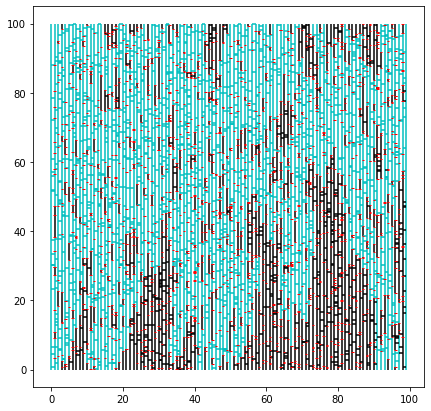

In [34]:
# some example variables
# height is how tall you want each wire to be
height = 100
# break_rate is the random poisson variable used to see how frequently there should be breaks in the wires
break_rate = 5
# num_wires is a function of the poisson 'break_rate' and the height of our grid. We use the greatest integer
# number of wires that fit within our grid where the wire spacing is defined by break_rate/5.
num_wires = math.floor(4.8*height/break_rate)
# similarly connect_rate determines how frequently there should be connections between the wires
# (the smaller the number, the more frequently it will happen)
connect_rate = 4.8

# We keep trying random grids until we find one that can reach the end, then draw it.
# We made the break rate slightly faster than the connect rate for an interesting path.
while True:
    breaks, connections = create_wires(height, num_wires, break_rate, connect_rate)
    reachable, verts, horiz = path_of_current(height, breaks, connections)
    if reachable:
        draw_wires_reachable(num_wires, verts, horiz, breaks)
        break

We now define $H_n(b,c)$ as follows:

<p style="text-align: center;"> $H_n(b, c) = \mathbb{P}($there exists a cyan path from left to right on the grid$)$ </p>

for our new wire percolation model, where $n$ is the height of the grid, $b$ is the Poisson break rate and $c$ is the Poisson connection rate.

Similarly to how we plotted $F_n(p)$ for a standard $n \times n$ grid, we will now plot $H_n(b, 5)$ for our wire percolation model. Keeping the connection rate constant we vary the break rate in an attempt to find the critical point. Note that the smaller the rate the faster it generates breaks. Again we call the critical point $P_c$, but this time we define it as:

<p style="text-align: center;"> $\lim_{n\to\infty}H_n(b, 5) = H(b) = \begin{cases}
0, & b > P_c\\
1, & b < P_c
\end{cases}$ , </p>

To do this we first create a function, `wires_Hn`, which computes $H_n$ for this model. We also create a function, `wire_percolation` to pass to `wires_Hn` which returns the result of each path check in the same way that `find_path_across` did for previous models.

In [1]:
# A function to compute whether a path was found for the parameters given
def wire_percolation(height, num_wires, break_rate, connect_rate):
    # we use 'create_wires' to generate our grid
    breaks, connections = create_wires(height, num_wires, break_rate, connect_rate)
    # we pass this grid to 'path_of_current' to check whether a path was found and return the result
    return path_of_current(height, breaks, connections)[0]

# A function to compute H_n for given height, break rate and connection rate
def wires_Hn(trials, height, num_wires, break_rate, connect_rate):
    '''
    This function finds Fn (the probability of a path from left to right) for a given grid size and probability of yellows.
    This is an estimate based on the number of successful vs unsuccessful trials.
    '''
    # we initialise a count function to note the trials which succeed in finding a path
    count = 0
    
    # we iterate 'trials' number of times, each time creating a grid and checking whether there is a path from left to right
    for i in range(trials):
        # when there is a path we increase 'count' by 1
        if wire_percolation(height, num_wires, break_rate, connect_rate):
            count += 1
    # we return the probability of finding a path, the number of successful trials divided by the total number of trials
    return 1.0 * count/trials

We now want to plot our results of $H_n$ and estimate a critical point $P_c$. We choose `wires_critical_point` to be an equivalent method of estimating $P_c$ as `Pc_at_0_5` for reasons we will detail below.

In [ ]:
# Function to plot H_n and estimate the critical point
def wires_critical_point(trials, h1, h2, num_wires, connect_rate):
    
    # We find H_n for 20 equally spaced break rates between 2 and 8 for each height n. I.e. every 0.2 break rates.
    x_vals = np.linspace(2, 8, 20)
    y_vals1 = np.array([wires_Hn(trials, h1, num_wires, break_rate, connect_rate) for break_rate in x_vals])
    y_vals2 = np.array([wires_Hn(trials, h2, num_wires, break_rate, connect_rate) for break_rate in x_vals])
    
    # Our estimate for the critical point using the x value corresponding to y=0.5
    critical = np.interp(0.5, y_vals1, x_vals)
    
    # Plot of both curves of H_n and our estimate of P_c
    plt.plot(x_vals, y_vals1, color='green', label=f'$height={h1}$')
    plt.plot(x_vals, y_vals2, color='cyan', label=f'$height={h2}$')
    plt.plot(critical, 0.5, 'o', color = 'green')
    plt.text(critical+0.018, 0.5, f"$P_c = {critical:.2f}$", ha="center")
    plt.axvline(critical, ls='--')
    plt.xlabel("Poisson Break Rate")
    plt.ylabel("Probability of Percolation")
    plt.title("Probability of Percolation for Wire Model")
    plt.legend()

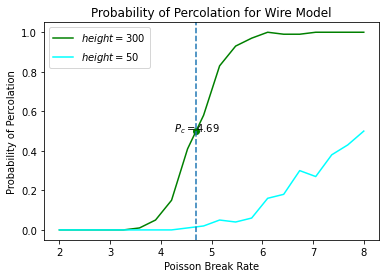

In [9]:
wires_critical_point(100, 300, 50, math.floor((4.8*height)/break_rate), 5)

The explanation of this task in the project description states that we should expect to find that the critical point is when the break rate and connection rate are equal. In this case then we should expect that $P_c = 5$. Clearly our estimate is fairly accurate then given it differs only by $0.31$ when we use $n = 300$. For larger $n$ we would expect this to be even more accurate, evidenced by the fact that for much smaller $n$, here $n = 50$, there appears to be no critical point at all. As a result we did not feel that an approach similar to that of `intercept_Pc` would be appropriate since it relies on an intercept of a smaller $n$. Looking at our graph if we had used $n = 50$ this would have given us no estimates within the correct range. A mthod like `greatest_gradient_Pc` may have been fairly accurate but, due to the propensity for outliers for insufficiently large $n$ and number of trials, we felt that an approach equivalent to `Pc_at_0_5` was best.

## Part 10 (Self Created Task): Dot Percolation Models

We also decided to create some of our own Percolation models using what we had learnt from this project. The first of these is a grid of a finite number of dots which are continuously generated as "on" and "off" (or yellow and blue) dots that follow these restraints:
* Choose a uniformly random x and y coordinate in the grid, and draw a dot with radius rad
* If the dot is not overlapping any others, it chooses to be on with probability p, and off with 1-p
* If it's only overlapping dots of the same colour, it will be the same colour as them
* If it's overlapping dots of different colours, then it's an invalid position, and chooses a new spot

This is an adaptation of a continuum disk percolation model described here [Stover].
Below is the function that generates this grid:

In [ ]:
def create_dots_clumping(width, height, p, rad, num_dots):

    # initialize the array of coordinates of dots, and their states (will be like [xcoord, ycoord, on/off])
    dot_coords = np.zeros((num_dots, 3))
    # we increase the number of dots drawn until we reach the desired amount, so start at 0 and stop when we're there
    current_dots = 0
    while current_dots < num_dots:
        # Start off with it being colourless
        colour = None
        # Clash is whether or not it's overlapping 2 different colours; it starts off not
        clash = False
        # generates a random point in the grid
        x, y = np.random.uniform(0,width), np.random.uniform(0,height)
        # Checking each of the previous dots
        for i in range(current_dots):
            # this is for optimisation - if the squares containing the dots overlap
            if abs(x - dot_coords[i][0]) + abs(y - dot_coords[i][1]) < 2*1.42*rad:
                # If the distance between the two dots is less than two radii (square both sides since sqrt is slow)
                if pow((x - dot_coords[i][0]), 2) + pow((y - dot_coords[i][1]), 2) < 4 * pow(rad, 2):
                    # If the dot is on
                    if dot_coords[i][2] == 1:
                        # and if the colour isnt already supposed to be off
                        if colour != 0:
                            # then the colour should now be on
                            colour = 1
                        # otherwise there's a clash, and we dont need to check anything else - just break and try again
                        else:
                            clash = True
                            break
                    # otherwise the dot is off
                    else:
                        # so same thing but in reverse
                        if colour != 1:
                            colour = 0
                        else:
                            clash = True
                            break
        # so long as it didnt clash, we can add it
        if not clash:
            # if we didnt assign it a colour already, then we choose it to be on with probability p
            if colour is None:
                colour = np.random.uniform() < p
            # then add the dot and it's colour to the dot coords
            dot_coords[current_dots] = [x, y, colour]
            # and since there's one more dot drawn, increase the counter by 1
            current_dots += 1
        tries += 1
        
    return dot_coords

We then want to draw these dots, in either yellow or blue depending on whether we have set them 'on' or 'off'

In [ ]:
# this takes graph dimensions, any number of arrays of dots, a list of colours and a radius size, and draws the dots
# on a graph, with the colours corresponding to list of lists of dots.
def draw_dots(width, height, dots_array, colours_array, rad):
    # gets graph stuff
    figure, axes = plt.subplots()
    # makes the graph background dark blue
    axes.set_facecolor('navy')

    # draws a circle in the correct colour at the correct coordinate for each of the dots
    for i, dots in enumerate(dots_array):
        for dot in dots:
            # creates a circle at the specified coordinate with the right radius and colour
            c = plt.Circle((dot[0], dot[1]), rad, color=colours_array[i])
            # then adds it to the axes
            axes.add_artist(c)

    # makes the graph a good size and shows it
    axes.set_xlim(0, width)
    axes.set_ylim(0, height)
    axes.set_aspect(1.0)
    plt.show()

For the purposes of finding a path from left to right, the off dots dont matter, so it would be helpful to trim them out of the list and only keep the useful data. The function below returns a list of only yellow dots, ignoring all those which are blue (or "off").

In [ ]:
def yellows_only(dots):
    yellows = []
    for dot in dots:
        if dot[2] == 1:
            yellows.append([dot[0], dot[1]])
    return yellows

Next we write a function which stores the dots we know to be reachable

In [ ]:
# Here we take a list of currently unreachable dots, reachable dots, and the dots that were just added (and the radius), 
# and see which of the unreachable dots are reachable from the just added dots. We then remove them
# from the unreachables and adds them to the reachables before assigning these dots as the new "last added" dots.
def add_new_dots(unlinked_dots, linked_dots, last_added, rad):
    # We cannot delete them from the array during the search since that would change how many items are in the array,
    # so we need to delete them after I've done all of the searching.
    to_delete = []
    new_dots = []
    # for each of the dots that arent yet reached
    for i in range(len(unlinked_dots)):
        # for each of the dots that were last added
        for j in range(len(last_added)):
            # if the current unlinked one is touching the current last powered
            if (unlinked_dots[i][0] - last_added[j][0]) ** 2 + (
                    unlinked_dots[i][1] - last_added[j][1]) ** 2 < 4 * rad ** 2:
                # add the unlinked dot to the linked dots
                linked_dots.append(unlinked_dots[i])
                # and also to the a temporary list that will become the last powered
                new_dots.append(unlinked_dots[i])
                # and add it's index to the array that will later bin it from the unlinked dots
                to_delete.append(i)
                # then since it's powered, we dont care if any other powered ones are touching it, so move on
                break
    # for each of the indexes that need deleting (in reverse order so it wont shift the index of other ones in the list)
    for i in to_delete[::-1]:
        # delete the corresponding dot in the unlinked dots
        del unlinked_dots[i]
    return unlinked_dots, linked_dots, new_dots

Finally we want to actually calculate our path utilising the dots we know to be reachable. The function below will also call `draw_dots` to draw the grid for us.

In [ ]:
# this function determines if there's a path of dots on a grid of "on" dots with a radius rad
def yellow_dot_path(width, height, dots, rad):
    # all dots start off unlinked
    unlinked_dots = dots

    # we start off by adding all dots that are touching the line x=0 to our linked dots - these are ones where the
    # x coordinate is < radius - so do a very similar thing to add_new_dots but taking this into account.
    linked_dots = []
    last_added = []
    to_remove = []

    # for each of the unlinked dots
    for i in range(len(unlinked_dots)):
        # if the dot is touching the left side
        if dots[i][0] < rad:
            # add it to linked dots
            linked_dots.append(unlinked_dots[i])
            # add it to last added
            last_added.append(unlinked_dots[i])
            # delete it from unlinked dots later
            to_remove.append(i)

    # delete all of the newly linked dots from unlinked dots
    for i in to_remove[::-1]:
        del unlinked_dots[i]

    # It starts off not reaching the end
    reached_end = False
    # while there are still unexplored dots and the end hasn't been reached
    while len(last_added) != 0 and not reached_end:
        # update the unlinked dots, linked dots, and last added dots
        unlinked_dots, linked_dots, last_added = add_new_dots(unlinked_dots, linked_dots, last_added, rad)
        # for each of the newly added dots
        for coords in last_added:
            # if any of them are touching the edge of the grid
            if coords[0] > width - rad:
                # then it's reachable!
                reached_end = True

    # draw the reached dots in yellow, and the unreached ones in red
    draw_dots(width, height, [unlinked_dots, linked_dots], ["crimson", "gold"], rad)
    
    if reached_end:
        return True
    else:
        return False

Below is a nice example of running this model. Red areas are those either not reachable or not yet found to be reachable by the time the model stops. Blue areas are forbidden and yellow areas map known reachable areas.

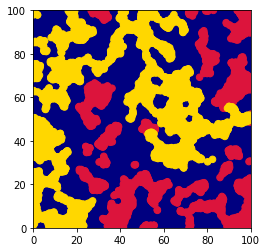

True

In [21]:
width, height = 100, 100
dot_radius = 1.5
num_dots = 15000
p_yellow = 0.55

dots = yellows_only(create_dots_clumping(width, height, p_yellow, dot_radius, num_dots))

yellow_dot_path(width, height, dots, dot_radius)

Unfortunately this process is extremely slow because `find_dots_clumping` in its current state must check every other dot already drawn and calculate a distance function before it can add a dot. Because this model is slow, we could instead just uniformly draw yellow dots on a blue grid and see whether there's a path going from left to right using the yellow dots. The function below creates the coordinates for these randomly generated dots. This is much faster as we need to plot far less dots. Again if we cannot check yet that a 'yellow' dot is reachable it appears red. A further exploration would be to make the spatial distribution of the dots a Poisson point process which may then lead to percolation threshold behaviour.

In [ ]:
# function that generates "num_dots" many random x and y coordinates
def create_dots_unif(width, height, num_dots):
    dot_coords = []
    for i in range(num_dots):
        # add a random coordinate to dot_coords, num_dots times
        dot_coords.append([np.random.uniform(0,width), np.random.uniform(0,height)])
    return dot_coords

We can then apply `yellow_dot_path` to this new grid and find a path much faster than with the previous model as we have far less checking to do.

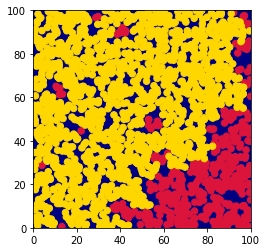

True

In [36]:
num_dots = 2000

dots = create_dots_unif(width,height,num_dots)
yellow_dot_path(width, height, dots, dot_radius)

An interesting calculation is to find if there exists a critical point at which the number of yellow dots plotted changes the probability of percolation from $0$ to $1$ for $100 \times 100$ grid with dot radius $1.5$. To do this we write two new functions below:

In [27]:
# Estimates the probability of a percolating path on a 100x100 grid for a given number of dots
def dots_perc(trials, num_dots):
    
    # # we initialise a count function to note the trials which succeed in finding a path
    count = 0
    
    # we iterate 'trials' number of times, each time creating a grid and checking whether there is a path from left to right
    for i in range(trials):
        dots = create_dots_unif(100, 100, num_dots)
        # when there is a path we increase 'count' by 1
        if yellow_dot_path(100, 100, dots, 1.5):
            count += 1
    # we return the probability of finding a path, the number of successful trials divided by the total number of trials        
    return 1.0 * count/trials

In [ ]:
# Plots the distribution of probabilities that a path is found for the random dot model
def dots_plot(trials):
    
    # Our x axis is the number of yellow dots generated. We calculate every 25 dots.
    x_vals = np.arange(1400, 1850, 25)
    # We find the estimated probability of a path for each number of dots in 'x_vals'
    y_vals = np.array([dots_perc(trials, num_dots) for num_dots in x_vals])
    
    # Plot of all three curves of Fn and our estimate of Pc
    plt.plot(x_vals, y_vals, color='cyan')
    plt.xlabel("Number of Yellow Dots")
    plt.ylabel("Probability of Percolation")
    plt.title(f"Probability of Percolation for Random Dot Model")

Unfortunately when we plotted this we found that there did not appear to be a percolation threshold for the number of dots as we theorised there might be. The graph below shows this because the probability of percolation appears to increase gradually with the number of dots. The randomness of the placement of dots means that there is greater variation in the probability of percolation at each number of dots. Given that a path is mainly a result of the density of dots, we do not believe that increasing the grid size would make a difference to the likelihood of critical point behaviour. This means that if we expect $1800$ dots on a $100 \times 100$ grid to likely give us a path then we would also expect $7200$ dots on a $200 \times 200$ grid to likely give us a path.

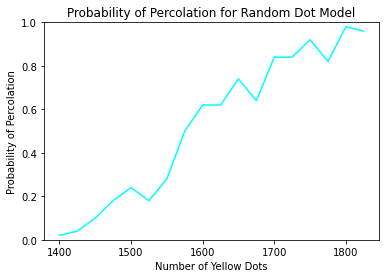

In [84]:
dots_plot(50)

## Part 11 (Self Created Task): Renormalization Approximation

Here, we explore an alternative way to find an approximation for the critical point, outlined in the “Renormalization Approximation” section here [Reluga, 2022]. An informal explanation for how it works would be, if we took an infinitely large grid and subdivided it into four quadrants and considered whether or not each of these smaller sub-grids percolated, we could possibly get a good approximation for the critical point by building an equation that relates the densities of this larger grid with the smaller grids, then setting the probability of the larger grid percolating equal to the probability of each of the smaller ones percolating.

This won’t give us an exact answer however, because even if the top left and top right quadrants of a grid percolate, that doesn't necessarily mean that the whole grid will - and similarly, even if none of them percolate, it’s still possible that the larger grid percolates. However, the hope is that the probabilities of these happening are low enough for us to get a good estimate; and it gives you a value that’s within $4\%$ of the true one!

However, if we subdivided it into smaller and smaller areas, in theory it should give you a more and more accurate result; so, this section explores these ideas. We wrote functions to figure out how many permutations of an $n \times n$ grid percolate given a specified number of “on” dots, and then calculate the corresponding equation for the gridsize, and plot it on a graph

In [ ]:
# function that takes a numpy array of 0s and 1s, interprets them as a binary number, and adds 1
def increment_binary_array(array):
    # gets each of the indices and corresponding items in an array
    for i, item in enumerate(array):
        # increases the current digit by 1
        item += 1
        # if you flipped a 0 to 1
        if item == 1:
            # then there's no overflow from this addition, so we can return it
            array[i] = item
            return array
        # If it is increased from a 1 to a 2
        if item == 2:
            # then set it as a 0, and move to the next digit
            array[i] = 0.0

In [ ]:
def renormalization_approximate(gridsize):
    # creates a dictionary of keys and values that correspond to values of x^n in the polynomial and their coefficients
    coeff_x_n = dict()
    # values from 0 to gridsize-1 wont be able to percolate so we only need to consider ones higher than that.
    for i in range(gridsize, gridsize**2+1):
        coeff_x_n[i] = 0

    # pattern is the binary number that is unique to each permutation of cells, starting off at all off.
    pattern = np.zeros(gridsize**2)
    # up to what would be all cells on
    for i in range(pow(2,gridsize**2)):
        # the number of on squares is just the sum of each of the digits in the binary number
        total_squares = sum(pattern)
        # if it's less than the width then it can't percolate and we can skip
        if total_squares >= gridsize:
            # otherwise, the grid is the 2d interpretation of the pattern
            grid = np.reshape(pattern, (gridsize, gridsize))
            # if it percolates
            if find_path_across(grid):
                # then add 1 to the corresponding coefficient in the polynomial
                coeff_x_n[total_squares] += 1
        # then go to the next binary number
        increment_binary_array(pattern)

    # gets an x axis for plotting it
    step = 0.0001
    x = np.arange(0.61,6.2+step, step)
    
    # function to output the result from plugging a value into the desired polynomial
    def poly_x(x, poly, gridsize):
        total = 0
        # for each of the powers in the dictionary
        for power in poly:
            # we add the coefficient * x^(power) * (1-x)^(width - power)
            total += poly[power]*pow(x, power) * pow(1-x, gridsize**2-power)
        # then subtract x from both sides of the final equation
        return total - x
    
    # Gets the y-axis and find the y_intercept
    y = poly_x(x,coeff_x_n, gridsize)
    func = inter.PchipInterpolator(x, y)
    x_intercept = opt.fsolve(func, 0.618)
    
    # Draws the line y = 0 and plots the x,y graph
    y = poly_x(x,coeff_x_n, gridsize)
    plt.hlines(0,0,1,"k")
    plt.plot(x,y, label = f"Grid size = {gridsize}")
    plt.plot(x_intercept,0,'o')
    plt.text(x_intercept+0.00005,0.00005, f"Pc = {x_intercept[0]:.3f}", color = "red", rotation=90, rotation_mode='anchor')
    plt.xlim(0.617, 0.62)
    plt.ylim(-0.0008, 0.0008)
    plt.ylabel("Constant of Polynomial Equation for Pc")
    plt.xlabel("Probability of Yellow")
    plt.legend()

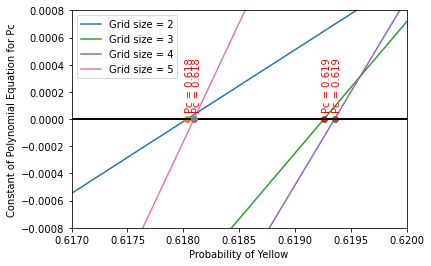

In [29]:
# Here we call the funciton for each grid size from 2 to 5, and plot the corresponding polynomials on a graph
renormalization_approximate(2)
renormalization_approximate(3)
renormalization_approximate(4)
renormalization_approximate(5)

plt.show()

As we can see above the approximations for grid sides $3$ and larger are surprisingly further than the true critical point than the $2 \times 2$ grid. Upon reflection, this is because we don't take whether or not the grid percolates from top to bottom into account; instead, we only take into account whether or not it percolates from left to right. We've made the assumption that if it percolates, it likely percolates from top to bottom, which is only true for very large grids and not for grids as small as $3 \times 3$. The reason that it’s so good for $2 \times 2$, is because it’s so small that there aren’t any paths that need you to percolate from top to bottom in order to cross, since it only has a height of $2$, so if there’s any path, it will always be one that can be crossed directly without moving up or down. However, when we reach $5 \times 5$ grids the critical point approximation starts to correct itself since as the probability of it percolating left to right and not top to bottom decreases due to the increased grid size.

There are other possible areas of exploration that could be expanded upon in the future, such as seeing if there’s some sort of pattern to the coefficients, and whether we could use them to get a good approximation for the next set for a grid size one larger. Additonally we could try re-writing the whole section to try and include data concerning whether or not the grid percolates top to bottom, as well as left to right.

These functions in their current state aren’t entirely useless, and if we could multithread it, heavily optimise it and run it on a supercomputer, we might be able to get a fairly accurate, repeatable estimate for our critical point. Unfortunately because the time complexity is so bad, and there are other methods (like the ideas we’ve explored earlier) that run significantly faster and give a more accurate results, this isn’t the best choice.

## Conclusion

In this project we attempted to explore a variety of percolation models, interpreting the differences between them and the reasoning behind such differences. Through our exploration of a variety of topics within percolation theory, we discovered several interesting behaviours, most notably that of critical points. We were able to estimate these points through computation on large grids, and, as we expected from the theory, the behaviour became more apparent the larger the grid we were able to compute. Although there were many computing challenges - including the trade off between the size of the grids, the precision of our estimates and the number of samples we could take - we ultimately managed to produce time and memory efficient, accurate estimates of critical points for a few percolation models. We aimed to evaluate different methods of estimation and apply the methods to scenarios in which they were most suitable and accurate. Finally, we were able to investigate interesting models of percolation such as the 'wire' and 'dot' models and then compare their behaviour to simpler models that we investigated initially.

## Bibliography

Zhukov, D., Samoylo, I., Brooks, J. and Hodges, V., 2016. Structural and Percolation Models of Intelligence. <em> Emerging Trends in Applications and Infrastructures for Computational Biology, Bioinformatics, and Systems Biology </em>, pp.333-340.

Christensen, K., 2002. <em>Percolation Theory</em>. [PDF] MIT, p.5. Available at: <https://web.mit.edu/ceder/publications/Percolation.pdf>

Stover, C. "Disk Model." From <em>MathWorld--A Wolfram Web Resource</em>, created by Eric W. Weisstein. Available at: <https://mathworld.wolfram.com/DiskModel.html>

Reluga, T., 2022. <em>Percolation</em>. [online] personal.psu.edu. Available at: <http://personal.psu.edu/tcr2/450/textbook/percolation.html?fbclid=IwAR2dZsMIOH5U57yMHDTUohx9Sgc_lvdL08VLWErxlwN_jZb_Dt5CTjRLKBc>